In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.stats import entropy
import ast
import collections
from tqdm.auto import tqdm
import ot
import sys
sys.path.append('./COOT/code')
import cot

sns.set()


In [2]:
def read_labels(path, dataset='ss-role'):
    label_data = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            if dataset in ['ss-func', 'ss-role', 'roberta']:
                word_info, word_label = line.strip().split('\t')
                sent_info, word = word_info.split(':')
                sent_info = ast.literal_eval(sent_info)
                label_data.append([sent_info[0], sent_info[1], word, word_label])
            elif dataset == 'dep':
                word_pair, word_label = line.strip().split('\t')
                word_pair = word_pair.split('--')
                if len(word_pair) == 2:
                    word1, word2 = word_pair
                elif len(word_pair) == 3:
                    word1, word2 = word_pair[0], '--'
                sent_info = [0, 0]
                label_data.append([sent_info[0], sent_info[1], f'{word1}--{word2}', word_label])
            else:
                raise ValueError('Dataset not supported')

    return pd.DataFrame(label_data, columns=['sent_id', 'word_id', 'word', 'label'])


def get_graph(dataset, dist_metric, filter, intervals, overlap, iteration, layer, datasplit):
    # make request to local server at port 5000 at \graph
    # with the query: {params: 'ss-role_euclidean_l2_50_50', iteration: 0, layer: 12, datasplit: 'train'}
    # and save the response as a variable
    r = requests.get(
        'http://localhost:5000/graph',
        params={
            'dataset': dataset,
            'epoch': iteration,
            'layer': layer,
            'dataSplit': datasplit,
            'metric': dist_metric,
            'filter': filter,
            'overlap': overlap,
            'intervals': intervals,
        })
    # params={'params': f'{dataset}_{dist_metric}_{filter}_{intervals}_{overlap}', 'iteration': iteration, 'layer': layer,
    # 'datasplit': datasplit})
    r.raise_for_status()
    data = r.json()
    graph = nx.json_graph.node_link_graph(data['graph'])
    return graph


def get_incidence(graph):
    return nx.incidence_matrix(graph).toarray()

# graphs = []

# for epoch in tqdm(range(0, 176, 5)):
#     graph = get_graph('ss-role', 'euclidean', 'l2', 50, 50, epoch, 9, 'train')
#     graphs.append(graph)


In [4]:
EPOCHS = list(range(0, 176, 5)) + [176]


def gw_distances(dataset, dist_metric, filter, intervals, overlap, layers, datasplit):
    layerwise_costs = {}

    for layer in layers:
        graphs = []

        for epoch in tqdm(EPOCHS, desc=f'Computing mapper graphs [Layer {layer}]'):
            graph = get_graph('ss-role', 'euclidean', 'l2', 50, 50, epoch, layer, 'train')
            graphs.append(graph)

        # compute cost w.r.t zero
        costs = []

        for graph in tqdm(graphs, desc='Computing costs'):
            g1, g2 = graphs[0], graph
            I1, I2 = get_incidence(g1), get_incidence(g2)
            Ts, Tv, cost = cot.cot_numpy(I1, I2, niter=2000, verbose=False)
            costs.append(cost)

        layerwise_costs[layer] = costs.copy()

    return layerwise_costs


layerwise_costs = gw_distances('ss-role', 'euclidean', 'l2', 50, 50, [1, 5, 9, 12], 'train')


Computing costs:  92%|█████████▏| 34/37 [00:12<00:01,  2.58it/s]c:\Users\archi\anaconda3\envs\probing\lib\site-packages\ot\lp\__init__.py:343: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
Computing costs: 100%|██████████| 37/37 [00:02<00:00, 18.23it/s]


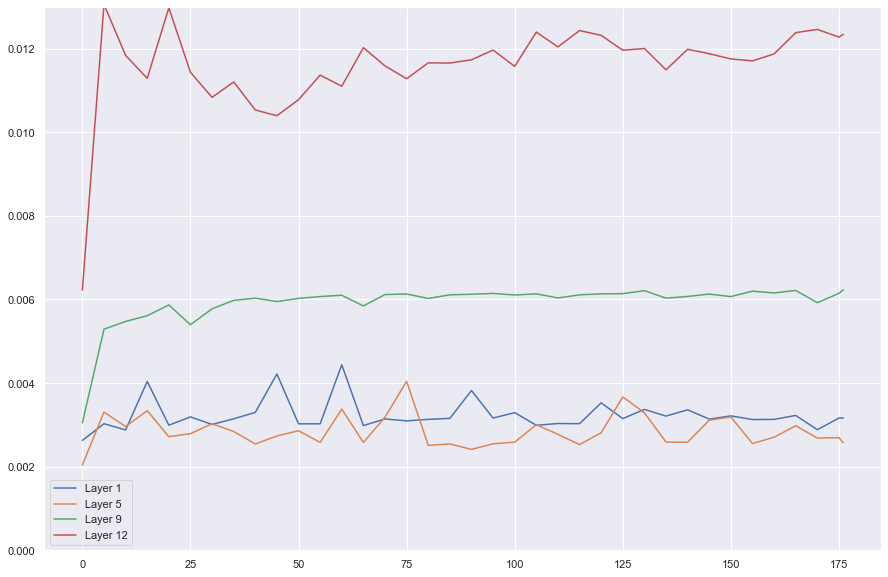

In [7]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_ylim(0, 0.013)

def plot_layerwise_costs(layerwise_costs):
    for layer, costs in layerwise_costs.items():
        ax.plot(EPOCHS, costs, label=f'Layer {layer}')
    plt.legend()
    # plt.show()

plot_layerwise_costs(layerwise_costs)
plt.savefig('./images/gramov-wasserstein/ss-role-layer1_5_9_12.png', dpi=300)

In [32]:


# cost_wrt_zero = []

# for graph in graphs:
#     g1, g2 = graphs[0], graph
#     I1, I2 = get_incidence(g1), get_incidence(g2)
#     Ts, Tv, cost = cot.cot_numpy(I1, I2, niter=2000, verbose=False)
#     cost_wrt_zero.append(cost)

# costs = np.zeros((len(graphs), len(graphs)))

# for i in tqdm(range(len(graphs))):
#     for j in range(i + 1, len(graphs)):
#         g1, g2 = graphs[i], graphs[j]
#         I1, I2 = get_incidence(g1), get_incidence(g2)
#         Ts, Tv, cost = cot.cot_numpy(I1, I2, niter=2000, verbose=False)
#         costs[i, j] = cost
#         costs[j, i] = cost


# g1 = get_graph('ss-func', 'euclidean', 'l2', 50, 50, 0, 12, 'train')
# I1 = np.array(nx.incidence_matrix(g1).todense().T)
# costs = []

# for epoch in tqdm(range(0, 176, 5)):
#     g2 = get_graph('ss-role', 'euclidean', 'l2', 50, 50, epoch, 12, 'train')
#     I2 = np.array(nx.incidence_matrix(g2).todense().T)
#     Ts, Tv, cost = cot.cot_numpy(I1, I2, niter=1000, verbose=False)
#     costs.append(cost)


<AxesSubplot:>

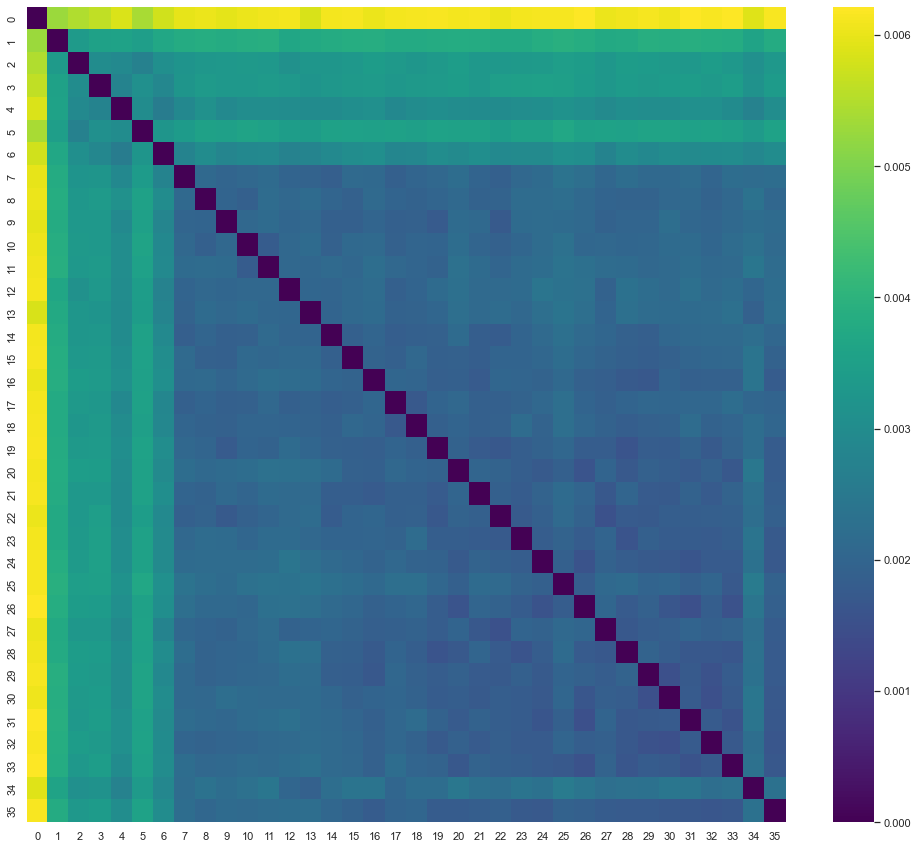

In [24]:
# plot heatmap of costs
plt.figure(figsize=(17, 15))
sns.heatmap(costs, cmap='viridis')

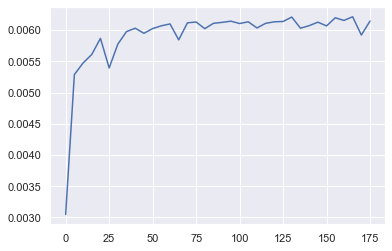

In [34]:
# plot change in costs between epochs
plt.plot(np.arange(0, 176, 5), cost_wrt_zero)

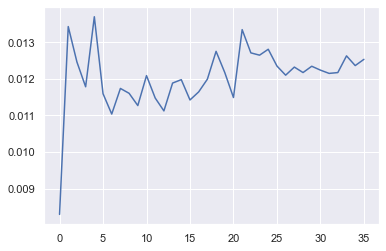

In [18]:
plt.plot(costs)

In [10]:
I1, I2 = np.array(nx.incidence_matrix(g1).todense().T), np.array(nx.incidence_matrix(g2).todense().T)
W1, W2 = nx.floyd_warshall_numpy(g1), nx.floyd_warshall_numpy(g2)

In [11]:
(len(g1.nodes()), len(g1.edges())), (len(g2.nodes()), len(g2.edges()))

((124, 70), (282, 208))

In [12]:
Ts, Tv, cost = cot.cot_numpy(I1, I2)

Delta: 0.1214095797313286  Loss: 0.015570782454790677
Delta: 0.1103153501009839  Loss: 0.013790017749351983
Delta: 0.09592517039020873  Loss: 0.01310493298739694
Delta: 0.08156380542979949  Loss: 0.012970414394573611
Delta: 0.07655017625686424  Loss: 0.012927345189699329
Delta: 0.07954988069608204  Loss: 0.012860046610904525
Delta: 0.07934247378916377  Loss: 0.012784325889164587
Delta: 0.0789928750991781  Loss: 0.012692562242150424
Delta: 0.074982919378144  Loss: 0.012651017193741959
Delta: 0.07542132802041507  Loss: 0.012558090788186864


In [13]:
cost

0.012558090788186864